# BrainStation Flaredown Capstone: Modeling

# Data Dictionary

* Age
* Country
* total_logs (the total number of logs for symptoms and conditions)
* total_log_rate_days (total number of logs divided by the date range)
* conditions_total (the total number of conditions [max=21])
* symptoms_total (the total number of symptoms [max=25])


Then, for each condition and symptom, I have included:

* symptom/condition(yes/no): 1 if they have logged this even once, 0 if they do not
* symptom/condition_total_logs (how many times they logged this)
* symptom/condition_activity (the median trackable_value number indicating how severe or intense the condition/symptom is, ranges from 0-4)
* symptom/condition_log_rate_days (the total number of logs divided by the date difference - closer to 1 is logging at least once a day in the date range)

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

from sklearn.metrics import plot_confusion_matrix, confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from tempfile import mkdtemp


In [4]:
import sklearn
print(sklearn.__version__)

1.1.1


In [5]:
df = pd.read_csv('data/chronic_agg.csv')

df.drop(columns=['Unnamed: 0'], inplace=True)

df

ids  age  gender country  total_logs  total_log_day_range  \
0         14   24  female      US           6                    0   
1         17   33  female      US          22                    1   
2         25   42    male      US           2                    0   
3         26   34    male      NL           2                    0   
4         28   32  female      US           4                    0   
...      ...  ...     ...     ...         ...                  ...   
17741  42267   43  female      CA         105                   35   
17742  42271   34  female      DE           6                   41   
17743  42273   34    male      LT         104                   12   
17744  42279   30   other      US        1110                 1003   
17745  42283   22  female      GB           6                    0   

       total_log_rate_days  conditions_total  fibro_comorbidities  migraine  \
0                 0.000000                 3                    1         1   
1                22.000000                 4                    1         1   
2                 0.000000                 0                    0         0   
3                 0.000000                 0                    0         0   
4                 0.000000                 2                    1         1   
...                    ...               ...                  ...       ...   
17741             3.000000                 3                    2         1   
17742             0.146341                 1                    1         1   
17743             8.666667                 2                    0         0   
17744             1.106680                 3                    2         1   
17745             0.000000                 3                    3         1   

       ...  lightheadedness_activity  lightheadedness_log_rate_days  \
0      ...                         0                       0.000000   
1      ...                         0                       0.000000   
2      ...                         0                       0.000000   
3      ...                         0                       0.000000   
4      ...                         0                       0.000000   
...    ...                       ...                            ...   
17741  ...                         0                       0.000000   
17742  ...                         0                       0.000000   
17743  ...                         1                       1.083333   
17744  ...                         0                       0.000000   
17745  ...                         0                       0.000000   

       shortness_of_breath  shortness_of_breath_total_logs  \
0                        0                               0   
1                        0                               0   
2                        0                               0   
3                        0                               0   
4                        0                               0   
...                    ...                             ...   
17741                    0                               0   
17742                    0                               0   
17743                    0                               0   
17744                    0                               0   
17745                    0                               0   

       shortness_of_breath_activity  shortness_of_breath_log_rate_days  \
0                                 0                                0.0   
1                                 0                                0.0   
2                                 0                                0.0   
3                                 0                                0.0   
4                                 0                                0.0   
...                             ...                                ...   
17741                             0                                0.0   
17742                        

In [6]:
df.fibromyalgia.value_counts() # have an imbalance problem

0    11233
1     6513
Name: fibromyalgia, dtype: int64

Converting Gender into Numeric

In [7]:
# Instantiate the OneHotEncoder
ohe = OneHotEncoder()
genders = pd.DataFrame(df["gender"])

# Fit the OneHotEncoder to the subcategory column and transform
# It expects a 2D array, so we first convert the column into a DataFrame
gen_encoded = ohe.fit_transform(genders)
gen_encoded
dense_gen_encoded = gen_encoded.toarray()

In [8]:
ohe.categories_

[array(['female', 'male', 'other'], dtype=object)]

In [9]:
# Check

gen_check = pd.DataFrame(dense_gen_encoded, columns=ohe.categories_, dtype=int)

gen_check

female male other
0          1    0     0
1          1    0     0
2          0    1     0
3          0    1     0
4          1    0     0
...      ...  ...   ...
17741      1    0     0
17742      1    0     0
17743      0    1     0
17744      0    0     1
17745      1    0     0

[17746 rows x 3 columns]

In [10]:
gen_check.columns = ['female', 'male', 'other']

gen_check.columns

Index(['female', 'male', 'other'], dtype='object')

In [11]:
# Reset index

gen_check.index = df.index

In [12]:
# Concatenating 

df2 = pd.concat([df,gen_check], axis=1)

df2.head(2)

ids  age  gender country  total_logs  total_log_day_range  \
0   14   24  female      US           6                    0   
1   17   33  female      US          22                    1   

   total_log_rate_days  conditions_total  fibro_comorbidities  migraine  ...  \
0                  0.0                 3                    1         1  ...   
1                 22.0                 4                    1         1  ...   

   shortness_of_breath_total_logs  shortness_of_breath_activity  \
0                               0                             0   
1                               0                             0   

   shortness_of_breath_log_rate_days  irritability  irritability_total_logs  \
0                                0.0             0                        0   
1                                0.0             0                        0   

   irritability_activity  irritability_log_rate_days  female  male  other  
0                      0                         0.0       1     0      0  
1                      0                         0.0       1     0      0  

[2 rows x 205 columns]

In [13]:
df2.groupby(by='fibromyalgia').total_log_day_range.value_counts().sort_values(ascending=False)

fibromyalgia  total_log_day_range
0             0                      4271
1             0                      2456
0             1                       857
              2                       526
1             1                       497
                                     ... 
0             752                       1
              751                       1
              748                       1
              746                       1
1             1649                      1
Name: total_log_day_range, Length: 1284, dtype: int64

# Test-Train Split and Scaling the Data

In [14]:
df2.columns.tolist()



['ids',
 'age',
 'gender',
 'country',
 'total_logs',
 'total_log_day_range',
 'total_log_rate_days',
 'conditions_total',
 'fibro_comorbidities',
 'migraine',
 'migraine_total_logs',
 'migraine_activity',
 'migraine_log_rate_days',
 'fibromyalgia',
 'fibromyalgia_total_logs',
 'fibromyalgia_activity',
 'fibromyalgia_log_rate_days',
 'pots',
 'pots_total_logs',
 'pots_activity',
 'pots_log_rate_days',
 'ehlers-danlos_syndrome',
 'ehlers-danlos_syndrome_total_logs',
 'ehlers-danlos_syndrome_activity',
 'ehlers-danlos_syndrome_log_rate_days',
 'irritable_bowel_syndrome',
 'irritable_bowel_syndrome_total_logs',
 'irritable_bowel_syndrome_activity',
 'irritable_bowel_syndrome_log_rate_days',
 'osteoarthritis',
 'osteoarthritis_total_logs',
 'osteoarthritis_activity',
 'osteoarthritis_log_rate_days',
 'depression',
 'depression_total_logs',
 'depression_activity',
 'depression_log_rate_days',
 'asthma',
 'asthma_total_logs',
 'asthma_activity',
 'asthma_log_rate_days',
 'anxiety',
 'anxiety

In [15]:
X_all = df2[['age',
'total_logs',
 'total_log_day_range',
 'total_log_rate_days',
 'conditions_total',
 'fibro_comorbidities',
 'migraine',
 'migraine_total_logs',
 'migraine_activity',
 'migraine_log_rate_days',
 'pots',
 'pots_total_logs',
 'pots_activity',
 'pots_log_rate_days',
 'ehlers-danlos_syndrome',
 'ehlers-danlos_syndrome_total_logs',
 'ehlers-danlos_syndrome_activity',
 'ehlers-danlos_syndrome_log_rate_days',
 'irritable_bowel_syndrome',
 'irritable_bowel_syndrome_total_logs',
 'irritable_bowel_syndrome_activity',
 'irritable_bowel_syndrome_log_rate_days',
 'osteoarthritis',
 'osteoarthritis_total_logs',
 'osteoarthritis_activity',
 'osteoarthritis_log_rate_days',
 'depression',
 'depression_total_logs',
 'depression_activity',
 'depression_log_rate_days',
 'asthma',
 'asthma_total_logs',
 'asthma_activity',
 'asthma_log_rate_days',
 'anxiety',
 'anxiety_total_logs',
 'anxiety_activity',
 'anxiety_log_rate_days',
 'arthritis',
 'arthritis_total_logs',
 'arthritis_activity',
 'arthritis_log_rate_days',
 'insomnia',
 'insomnia_total_logs',
 'insomnia_activity',
 'insomnia_log_rate_days',
 'endometriosis',
 'endometriosis_total_logs',
 'endometriosis_activity',
 'endometriosis_log_rate_days',
 'gerd',
 'gerd_total_logs',
 'gerd_activity',
 'gerd_log_rate_days',
 'lupus',
 'lupus_total_logs',
 'lupus_activity',
 'lupus_log_rate_days',
 'post-traumatic_stress_disorder_(ptsd)',
 'post-traumatic_stress_disorder_(ptsd)_total_logs',
 'post-traumatic_stress_disorder_(ptsd)_activity',
 'post-traumatic_stress_disorder_(ptsd)_log_rate_days',
 'chronic_fatigue_syndrome',
 'chronic_fatigue_syndrome_total_logs',
 'chronic_fatigue_syndrome_activity',
 'chronic_fatigue_syndrome_log_rate_days',
 'rheumatoid_arthritis',
 'rheumatoid_arthritis_total_logs',
 'rheumatoid_arthritis_activity',
 'rheumatoid_arthritis_log_rate_days',
 'polycystic_ovary_syndrome_(pcos)',
 'polycystic_ovary_syndrome_(pcos)_total_logs',
 'polycystic_ovary_syndrome_(pcos)_activity',
 'polycystic_ovary_syndrome_(pcos)_log_rate_days',
 'headaches',
 'headaches_total_logs',
 'headaches_activity',
 'headaches_log_rate_days',
 'symptoms_total',
 'fatigue',
 'fatigue_total_logs',
 'fatigue_activity',
 'fatigue_log_rate_days',
 'back_pain',
 'back_pain_total_logs',
 'back_pain_activity',
 'back_pain_log_rate_days',
 'chronic_pain',
 'chronic_pain_total_logs',
 'chronic_pain_activity',
 'chronic_pain_log_rate_days',
 'joint_pain',
 'joint_pain_total_logs',
 'joint_pain_activity',
 'joint_pain_log_rate_days',
 'stomach_pain',
 'stomach_pain_total_logs',
 'stomach_pain_activity',
 'stomach_pain_log_rate_days',
 'headache',
 'headache_total_logs',
 'headache_activity',
 'headache_log_rate_days',
 'muscle_pain',
 'muscle_pain_total_logs',
 'muscle_pain_activity',
 'muscle_pain_log_rate_days',
 'shoulder_pain',
 'shoulder_pain_total_logs',
 'shoulder_pain_activity',
 'shoulder_pain_log_rate_days',
 'bloating',
 'bloating_total_logs',
 'bloating_activity',
 'bloating_log_rate_days',
 'abdominal_pain',
 'abdominal_pain_total_logs',
 'abdominal_pain_activity',
 'abdominal_pain_log_rate_days',
 'knee_pain',
 'knee_pain_total_logs',
 'knee_pain_activity',
 'knee_pain_log_rate_days',
 'brain_fog',
 'brain_fog_total_logs',
 'brain_fog_activity',
 'brain_fog_log_rate_days',
 'fatigue_and_tiredness',
 'fatigue_and_tiredness_total_logs',
 'fatigue_and_tiredness_activity',
 'fatigue_and_tiredness_log_rate_days',
 'constipation',
 'constipation_total_logs',
 'constipation_activity',
 'constipation_log_rate_days',
 'neck_pain',
 'neck_pain_total_logs',
 'neck_pain_activity',
 'neck_pain_log_rate_days',
 'diarrhea',
 'diarrhea_total_logs',
 'diarrhea_activity',
 'diarrhea_log_rate_days',
 'dizziness',
 'dizziness_total_logs',
 'dizziness_activity',
 'dizziness_log_rate_days',
 'joint_stiffness',
 'joint_stiffness_total_logs',
 'joint_stiffness_activity',
 'joint_stiffness_log_rate_days',
 'nausea',
 'nausea_total_logs',
 'nausea_activity',
 'nausea_log_rate_days',
 'chest_pain',
 'chest_pain_total_logs',
 'chest_pain_activity',
 'chest_pain_log_rate_days',
 'hip_pain',
 'hip_pain_total_logs',
 'hip_pain_activity',
 'hip_pain_log_rate_days',
 'muscle_spasms',
 'muscle_spasms_total_logs',
 'muscle_spasms_activity',
 'muscle_spasms_log_rate_days',
 'hand_pain',
 'hand_pain_total_logs',
 'hand_pain_activity',
 'hand_pain_log_rate_days',
 'leg_pain',
 'leg_pain_total_logs',
 'leg_pain_activity',
 'leg_pain_log_rate_days',
 'menstrual_cramps',
 'menstrual_cramps_total_logs',
 'menstrual_cramps_activity',
 'menstrual_cramps_log_rate_days',
 'vomiting',
 'vomiting_total_logs',
 'vomiting_activity',
 'vomiting_log_rate_days',
 'lightheadedness',
 'lightheadedness_total_logs',
 'lightheadedness_activity',
 'lightheadedness_log_rate_days',
 'shortness_of_breath',
 'shortness_of_breath_total_logs',
 'shortness_of_breath_activity',
 'shortness_of_breath_log_rate_days',
 'irritability',
 'irritability_total_logs',
 'irritability_activity',
 'irritability_log_rate_days',
 'female',
 'other']]

y = df2['fibromyalgia']

In [ ]:
X_conds = df2[['age',
'total_logs',
 'total_log_day_range',
 'total_log_rate_days',
 'conditions_total',
 'fibro_comorbidities',
 'migraine',
 'pots',
 'ehlers-danlos_syndrome',
 'irritable_bowel_syndrome',
 'osteoarthritis',
 'depression',
 'asthma',
 'anxiety',
 'arthritis',
 'insomnia',
 'endometriosis',
 'gerd',
 'lupus',
 'post-traumatic_stress_disorder_(ptsd)',
 'chronic_fatigue_syndrome',
 'rheumatoid_arthritis',
 'polycystic_ovary_syndrome_(pcos)',
 'headaches',
 'symptoms_total',
 'fatigue',
 'back_pain',
 'chronic_pain',
 'joint_pain',
 'stomach_pain',
 'headache',
 'muscle_pain',
 'shoulder_pain',
 'bloating',
 'abdominal_pain',
 'knee_pain',
 'brain_fog',
 'fatigue_and_tiredness',
 'constipation',
 'neck_pain',
 'diarrhea',
 'dizziness',
 'joint_stiffness',
 'nausea',
 'chest_pain',
 'hip_pain',
 'muscle_spasms',
 'hand_pain',
 'leg_pain',
 'menstrual_cramps',
 'vomiting',
 'lightheadedness',
 'shortness_of_breath',
 'irritability',
 'female',
 'other']]

In [16]:
X_all.corr().style.background_gradient()

In [17]:
from sklearn.metrics import matthews_corrcoef

In [18]:
X_basic = df2[['female',
 'other', 'age',
 'total_logs',
 'total_log_day_range',
 'total_log_rate_days',
 'conditions_total',
 'fibro_comorbidities']]

## All Variables

In [19]:
df2.shape

(17746, 205)

In [20]:
# Creating the remainder and test sets all variables
X_remainder, X_test, y_remainder, y_test = train_test_split(X_all, y, test_size=0.3, random_state=1, stratify=y)

In [21]:
print(X_remainder.shape)
print(X_test.shape)

print(y_remainder.shape)
print(y_test.shape)

(12422, 197)
(5324, 197)
(12422,)
(5324,)


In [22]:
y_remainder.value_counts(normalize=True)

0    0.63299
1    0.36701
Name: fibromyalgia, dtype: float64

In [23]:
y_test.value_counts(normalize=True)

0    0.632983
1    0.367017
Name: fibromyalgia, dtype: float64

In [24]:
# creating the train and validation sets for all variables
X_train, X_validation, y_train, y_validation = train_test_split(X_remainder, y_remainder, test_size=0.3, random_state=1, stratify=y_remainder)

In [25]:
print(X_train.shape)
print(X_validation.shape)

print(y_train.shape)
print(y_validation.shape)

(8695, 197)
(3727, 197)
(8695,)
(3727,)


In [26]:
y_train.value_counts(normalize=True)

0    0.633007
1    0.366993
Name: fibromyalgia, dtype: float64

In [27]:
y_validation.value_counts(normalize=True)

0    0.632949
1    0.367051
Name: fibromyalgia, dtype: float64

In [28]:
# Pipeline and gridsearch for LR
ks = np.arange(1,100, step=1)
depths = np.arange(1,20, step=1)

estimators = [('normalise', MinMaxScaler()),
              ('model', LogisticRegression())]

pipe = Pipeline(estimators)

param_grid = [
            {'normalise': [MinMaxScaler(), None],
             'model': [LogisticRegression()], 
             'model__C': [0.001, 0.01, 0.1, 1, 10, 100],
             'model__solver': ['saga'],
             'model__penalty': ['l2', 'l1'],
             'model__max_iter': [10000]}
]

# grid = GridSearchCV(pipe, param_grid, cv=5)
# fittedgrid = grid.fit(X_train, y_train)

In [29]:
# Pipeline and gridsearch for KNN
ks = np.arange(1,100, step=1)
depths = np.arange(1,20, step=1)

estimators = [('normalise', MinMaxScaler()),
              ('model', LogisticRegression())]

pipe = Pipeline(estimators)

param_grid = [
             {'normalise': [MinMaxScaler(), None],
             'model': [KNeighborsClassifier()],
             'model__n_neighbors': [ks]}
]

# grid = GridSearchCV(pipe, param_grid, cv=5)
# fittedgrid = grid.fit(X_train, y_train)

In [30]:
# fittedgrid.score(X_train, y_train)

In [31]:
# fittedgrid.score(X_validation, y_validation)

In [32]:
# fittedgrid.best_params_

Decision Tree

In [33]:
# Trying a tree to get a sense for amount of multicolinearity
train_acc = list()
val_acc = list()

depths = np.arange(1, 25, step=1)

for dep in depths:
    Tree = DecisionTreeClassifier(max_depth=dep)

    Tree.fit(X_train, y_train)
    TAC = Tree.score(X_train, y_train)
    VAC = Tree.score(X_validation, y_validation)

    train_acc.append(TAC)
    val_acc.append(VAC)


In [34]:
depths

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])

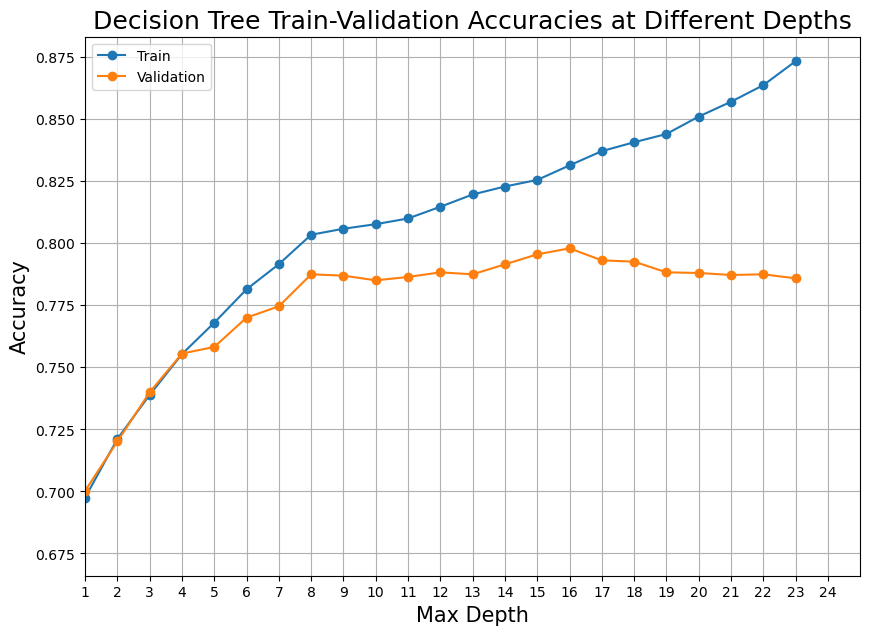

In [35]:
plt.figure(figsize=(10,7))
plt.plot(train_acc, label='Train', marker='o')
plt.plot(val_acc, label='Validation', marker='o')
plt.xticks(np.arange(1,25, step=1))
plt.xlim(1,25)
plt.xlabel('Max Depth', size=15)
plt.ylabel("Accuracy", size=15)
plt.title('Decision Tree Train-Validation Accuracies at Different Depths', size=18)
plt.grid()
plt.legend()

plt.show()

In [36]:
# Fit with max_depth of 20

MyTree = DecisionTreeClassifier(max_depth=8)

MyTree.fit(X_remainder, y_remainder)

MyTree.score(X_remainder, y_remainder)


0.7921429721461922

In [37]:
MyTree.score(X_test, y_test)

0.7922614575507138

Logistic Regression

In [38]:
# test with validation and train
scale1 = MinMaxScaler()

scale1.fit(X_train)

X_train_scaled = scale1.transform(X_train)

X_validation_scaled = scale1.transform(X_validation)

In [39]:
train_acc = list()
val_acc = list()

Cs = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]

for C in Cs:

    LR = LogisticRegression(C=C, max_iter=10000, solver='saga', penalty='l2')

    LR.fit(X_train_scaled, y_train)
    LR.fit(X_train_scaled, y_train)
    

    TAC = LR.score(X_train_scaled, y_train)
    VAC = LR.score(X_validation_scaled, y_validation)

    train_acc.append(TAC)
    val_acc.append(VAC)

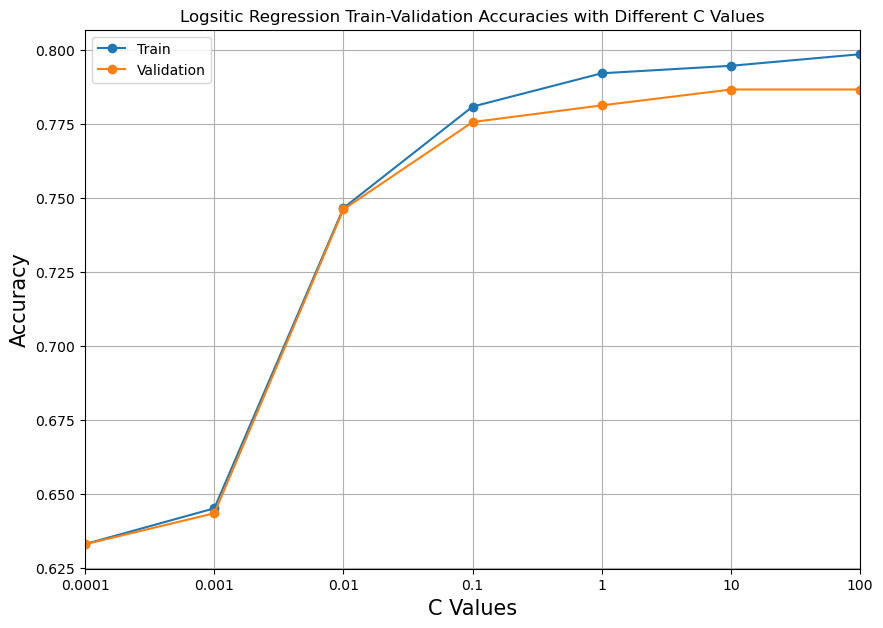

In [40]:
plt.figure(figsize=(10,7))
plt.plot(train_acc, label='Train', marker='o')
plt.plot(val_acc, label='Validation', marker='o')
plt.xticks([0,1,2,3,4,5,6], labels=Cs)
plt.xlabel('C Values', size=15)
plt.ylabel("Accuracy", size=15)
plt.title("Logsitic Regression Train-Validation Accuracies with Different C Values")
plt.xlim(0,6)
plt.grid()
plt.legend()

plt.show()

KNN

In [41]:
train_acc = list()
val_acc = list()

Ks = (np.arange(1,200, step=5))

for K in Ks:
    KNN = KNeighborsClassifier(n_neighbors=K)

    KNN.fit(X_train_scaled, y_train)

    TAC = KNN.score(X_train_scaled, y_train)
    VAC = KNN.score(X_validation_scaled, y_validation)

    train_acc.append(TAC)
    val_acc.append(VAC)

In [42]:
labels=list(Ks)

In [43]:
len(train_acc)

40

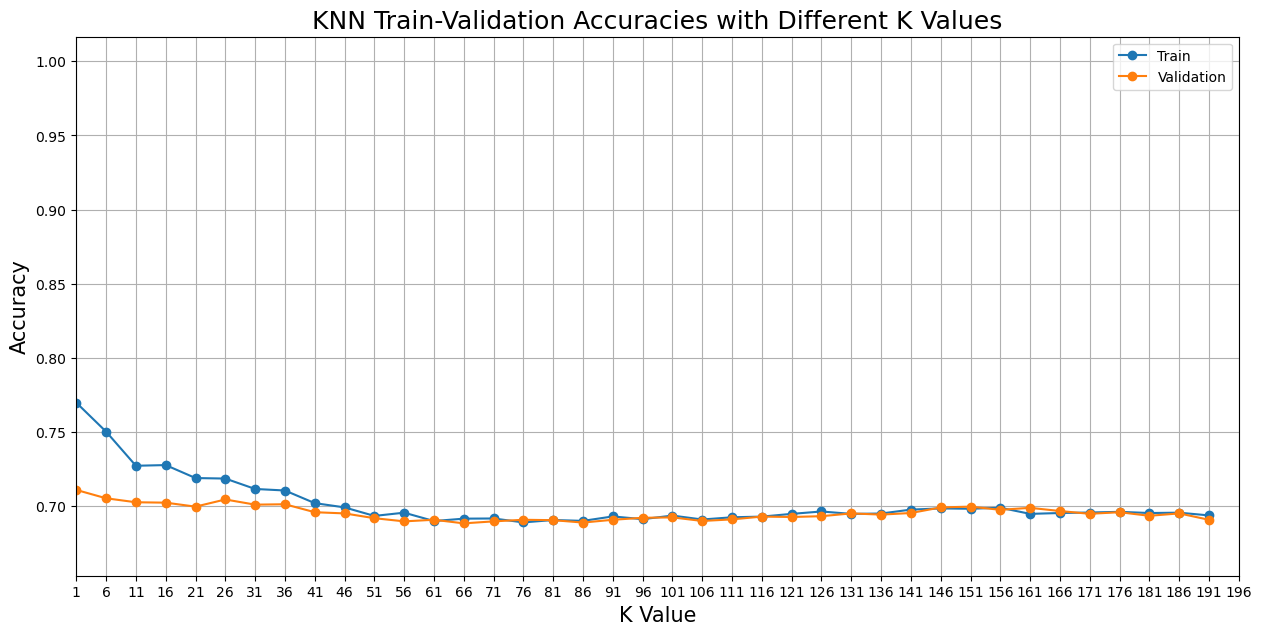

In [44]:
plt.figure(figsize=(15,7))
plt.plot(train_acc, label='Train', marker='o')
plt.plot(val_acc, label='Validation', marker='o')
plt.xticks((np.arange(1,41, step=1)), labels=labels)
plt.xlim(1,40)
plt.xlabel('K Value', size=15)
plt.ylabel("Accuracy", size=15)
plt.title("KNN Train-Validation Accuracies with Different K Values", size=18)
plt.grid()
plt.legend()

plt.show()

In [45]:
# Fitting with C = 10, l2 pentalty 

My_LR = LogisticRegression(max_iter=10000, C=100, penalty='l2', solver='saga')

My_LR.fit(X_train_scaled, y_train)

print(f"The train accuacy is: {My_LR.score(X_train_scaled, y_train)}")
print(f'The model accuracy is: {My_LR.score(X_validation_scaled, y_validation)}')

The train accuacy is: 0.798619896492237
The model accuracy is: 0.78669170914945


In [46]:
scale2 = MinMaxScaler()

scale2.fit(X_remainder)

X_remainder_scaled = scale2.transform(X_remainder)

X_test_scaled = scale2.transform(X_test)

In [47]:
# Fitting with C = 10, l2 pentalty 

My_LR = LogisticRegression(max_iter=10000, C=10, penalty='l2', solver='saga')

My_LR.fit(X_remainder_scaled, y_remainder)

print(f"The train accuacy is: {My_LR.score(X_remainder_scaled, y_remainder)}")
print(f'The model accuracy is: {My_LR.score(X_test_scaled, y_test)}')

The train accuacy is: 0.7931090001610047
The model accuracy is: 0.7843726521412472


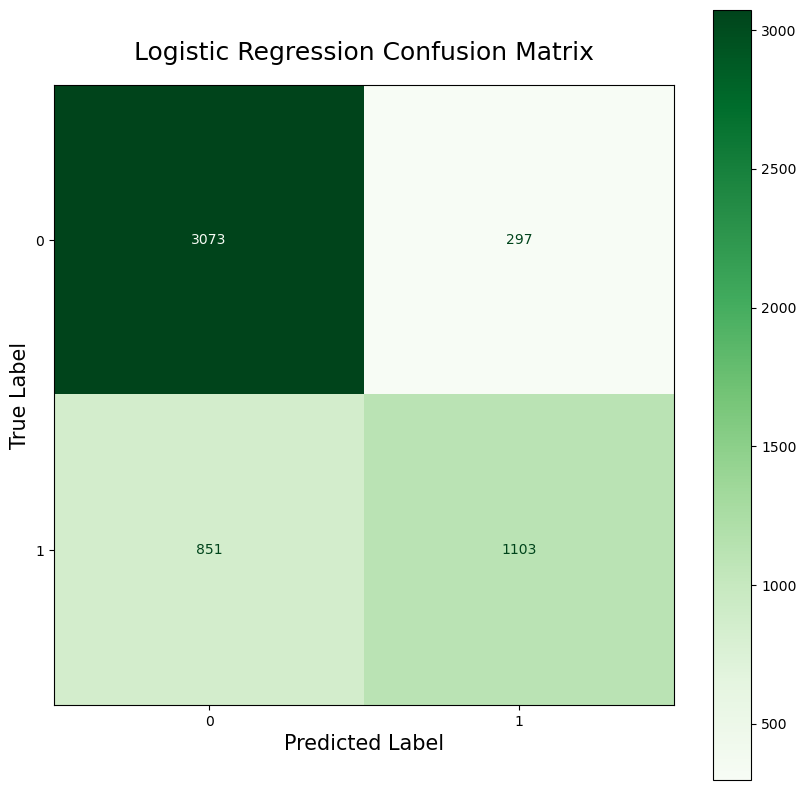

In [48]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get class predictions
y_pred = My_LR.predict(X_test_scaled)

# Generate confusion matrix

disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Greens')
fig = disp.ax_.get_figure() 
fig.set_figwidth(10)
fig.set_figheight(10)
plt.title("Logistic Regression Confusion Matrix", size=18, pad=18)
plt.ylabel('True Label', size=15)
plt.xlabel('Predicted Label', size=15)
plt.savefig('WHAT.png')

plt.show()

In [49]:
report_initial = classification_report(y_test, y_pred)

print(report_initial)

              precision    recall  f1-score   support

           0       0.78      0.91      0.84      3370
           1       0.79      0.56      0.66      1954

    accuracy                           0.78      5324
   macro avg       0.79      0.74      0.75      5324
weighted avg       0.78      0.78      0.77      5324



In [50]:
# Prediction probabilities for the test set

fibro_probabilities = My_LR.predict_proba(X_test_scaled)[:,1].round(2)
fibro_hard_pred = My_LR.predict(X_test_scaled)

X_test_with_probs = X_test.copy()

X_test_with_probs['Fibromyalgia_Porbability'] = fibro_probabilities

X_test_with_probs['Fibromyalgia'] = y_test

fibro_hard_pred

array([0, 1, 0, ..., 0, 0, 1], dtype=int64)

<AxesSubplot:xlabel='Fibromyalgia_Porbability', ylabel='count'>

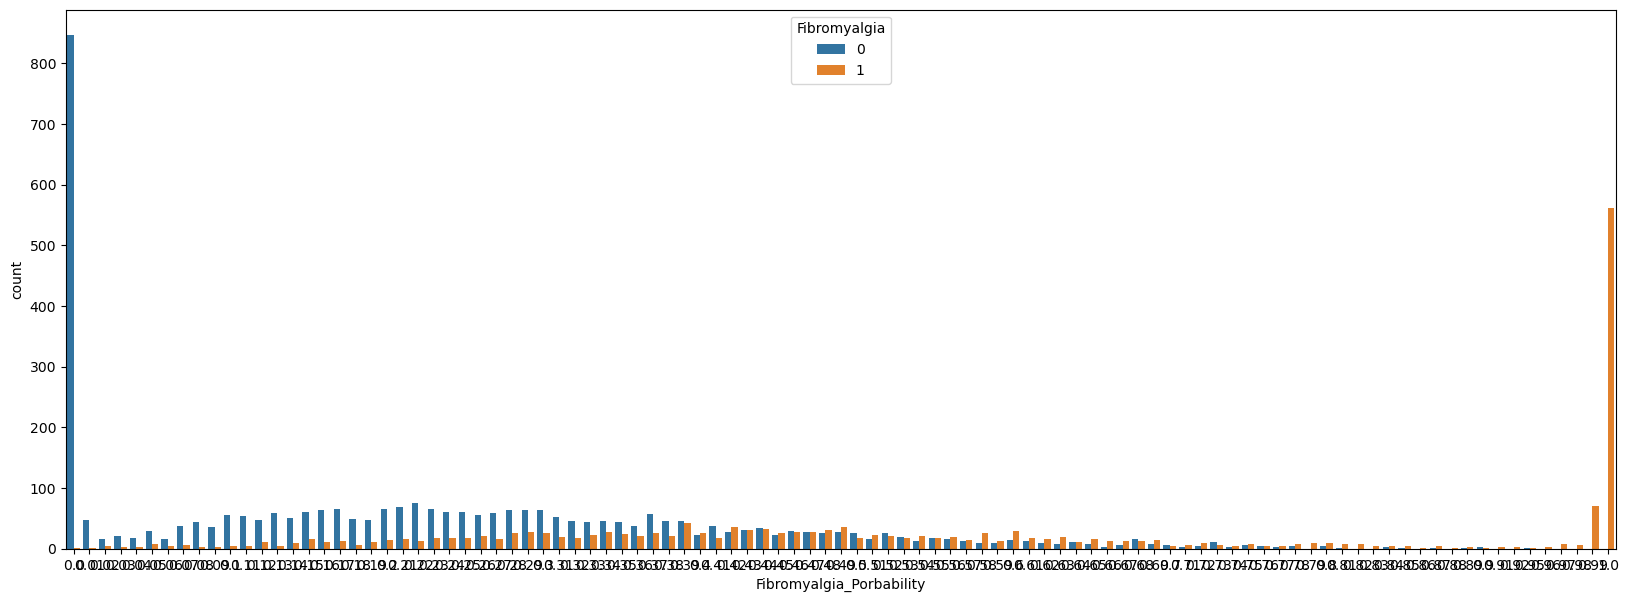

In [51]:
plt.figure(figsize=(20,7))
sns.countplot(data=X_test_with_probs, x='Fibromyalgia_Porbability', hue='Fibromyalgia')

In [52]:
labels = X_all.columns
labels

Index(['age', 'total_logs', 'total_log_day_range', 'total_log_rate_days',
       'conditions_total', 'fibro_comorbidities', 'migraine',
       'migraine_total_logs', 'migraine_activity', 'migraine_log_rate_days',
       ...
       'shortness_of_breath', 'shortness_of_breath_total_logs',
       'shortness_of_breath_activity', 'shortness_of_breath_log_rate_days',
       'irritability', 'irritability_total_logs', 'irritability_activity',
       'irritability_log_rate_days', 'female', 'other'],
      dtype='object', length=197)

In [53]:
coefs = pd.DataFrame(data=My_LR.coef_, columns = labels)

coefs

age  total_logs  total_log_day_range  total_log_rate_days  \
0  1.507341    7.622855             0.931777            14.322582   

   conditions_total  fibro_comorbidities  migraine  migraine_total_logs  \
0          0.994206            -0.045321  0.153404            -1.976697   

   migraine_activity  migraine_log_rate_days  ...  shortness_of_breath  \
0          -0.601999               -2.172481  ...            -5.307631   

   shortness_of_breath_total_logs  shortness_of_breath_activity  \
0                        -0.15438                     -1.488141   

   shortness_of_breath_log_rate_days  irritability  irritability_total_logs  \
0                          -0.956336      -5.07318                 -0.12669   

   irritability_activity  irritability_log_rate_days    female     other  
0              -1.545898                    -0.98273  0.903682  0.862425  

[1 rows x 197 columns]

In [54]:
df_coef_all = coefs.T

df_coef_all.columns = ['Log_Coefficients']

df_coef_all

Log_Coefficients
age                                 1.507341
total_logs                          7.622855
total_log_day_range                 0.931777
total_log_rate_days                14.322582
conditions_total                    0.994206
...                                      ...
irritability_total_logs            -0.126690
irritability_activity              -1.545898
irritability_log_rate_days         -0.982730
female                              0.903682
other                               0.862425

[197 rows x 1 columns]

In [55]:

to_convert = df_coef_all['Log_Coefficients']

converted = list()

typeCoef = list()

for coef in to_convert:
    if coef > 0:
        print(f"The coefficient is {coef}")
        odds = np.exp(coef) # convers to odds ratio
        print(f'Here is the odds: {odds}')
        prob = odds/(odds+1)*100 # Converts to probability
        print(f"The percent likelihood increase is {prob}")
        converted.append(prob) #Appends to a list
        typeCoef.append("Increase") # adds the type (increase) to a list
    elif coef < 0: # repeat for negative coefficients
        print(f"The coefficient is {coef}")
        odds = np.exp(coef)
        print(f'Here is the odds: {odds}')
        prob = odds/(odds+1)*100
        print(f"The percent likelihood decrease is {prob}")
        converted.append(prob)
        typeCoef.append("Decrease")
        
df_coef_all['Coefficient_Type'] = typeCoef # Adding these to the pos dataframe
df_coef_all['Percent_Change'] = converted


The coefficient is 1.5073407444733382
Here is the odds: 4.514709051958613
The percent likelihood increase is 81.86667708888761
The coefficient is 7.622855109566857
Here is the odds: 2044.390764796994
The percent likelihood increase is 99.95110958662711
The coefficient is 0.9317765904053685
Here is the odds: 2.5390159644768877
The percent likelihood increase is 71.74355781274886
The coefficient is 14.322582416729666
Here is the odds: 1660422.1192799108
The percent likelihood increase is 99.99993977438712
The coefficient is 0.9942060090183467
Here is the odds: 2.7025776668774517
The percent likelihood increase is 72.99178869505405
The coefficient is -0.04532104967260735
Here is the odds: 0.9556906084179845
The percent likelihood decrease is 48.86716765445178
The coefficient is 0.15340393737762065
Here is the odds: 1.165795792341971
The percent likelihood increase is 53.827595217614885
The coefficient is -1.9766965666275957
Here is the odds: 0.13852609401951632
The percent likelihood decr

In [56]:
df_coef_all.head(20)

Log_Coefficients Coefficient_Type  \
age                                           1.507341         Increase   
total_logs                                    7.622855         Increase   
total_log_day_range                           0.931777         Increase   
total_log_rate_days                          14.322582         Increase   
conditions_total                              0.994206         Increase   
fibro_comorbidities                          -0.045321         Decrease   
migraine                                      0.153404         Increase   
migraine_total_logs                          -1.976697         Decrease   
migraine_activity                            -0.601999         Decrease   
migraine_log_rate_days                       -2.172481         Decrease   
pots                                         -0.992279         Decrease   
pots_total_logs                              -1.502265         Decrease   
pots_activity                                -0.271950         Decrease   
pots_log_rate_days                           -0.382673         Decrease   
ehlers-danlos_syndrome                       -0.929517         Decrease   
ehlers-danlos_syndrome_total_logs             1.384480         Increase   
ehlers-danlos_syndrome_activity              -0.551477         Decrease   
ehlers-danlos_syndrome_log_rate_days         -0.291165         Decrease   
irritable_bowel_syndrome                      0.122049         Increase   
irritable_bowel_syndrome_total_logs          -1.225777         Decrease   

                                      Percent_Change  
age                                        81.866677  
total_logs                                 99.951110  
total_log_day_range                        71.743558  
total_log_rate_days                        99.999940  
conditions_total                           72.991789  
fibro_comorbidities                        48.867168  
migraine                                   53.827595  
migraine_total_logs                        12.167143  
migraine_activity                          35.388656  
migraine_log_rate_days                     10.224911  
pots                                       27.046212  
pots_total_logs                            18.208802  
pots_activity                              43.242855  
pots_log_rate_days                         40.548240  
ehlers-danlos_syndrome                     28.302266  
ehlers-danlos_syndrome_total_logs          79.970962  
ehlers-danlos_syndrome_activity            36.552171  
ehlers-danlos_syndrome_log_rate_days       42.771873  
irritable_bowel_syndrome                   53.047452  
irritable_bowel_syndrome_total_logs        22.692133

In [57]:
fibro_coefs = df_coef_all[df_coef_all['Coefficient_Type'] == 'Increase']

fibro_coefs.sort_values('Percent_Change', ascending=False).head(50)

Log_Coefficients  \
total_log_rate_days                                        14.322582   
total_logs                                                  7.622855   
post-traumatic_stress_disorder_(ptsd)                       6.070346   
gerd                                                        5.901762   
muscle_spasms                                               5.747214   
leg_pain                                                    5.648911   
joint_stiffness                                             5.243347   
hand_pain                                                   5.204392   
osteoarthritis                                              4.677231   
arthritis                                                   4.641969   
polycystic_ovary_syndrome_(pcos)_total_logs                 3.237820   
diarrhea_total_logs                                         3.010652   
stomach_pain_total_logs                                     2.402117   
leg_pain_activity                                           2.152462   
arthritis_activity                                          2.101880   
joint_stiffness_activity                                    2.081674   
constipation_total_logs                                     1.819451   
post-traumatic_stress_disorder_(ptsd)_log_rate_...          1.769092   
hand_pain_activity                                          1.708664   
muscle_spasms_activity                                      1.676690   
gerd_activity                                               1.651565   
asthma_total_logs                                           1.626661   
osteoarthritis_activity                                     1.620998   
abdominal_pain_total_logs                                   1.524270   
age                                                         1.507341   
ehlers-danlos_syndrome_total_logs                           1.384480   
muscle_pain_activity                                        1.244034   
leg_pain_log_rate_days                                      1.135635   
gerd_log_rate_days                                          1.002176   
conditions_total                                            0.994206   
total_log_day_range                                         0.931777   
female                                                      0.903682   
hand_pain_log_rate_days                                     0.891348   
chest_pain_activity                                         0.885655   
other                                                       0.862425   
fatigue_and_tiredness_total_logs                            0.862192   
muscle_spasms_log_rate_days                                 0.842090   
post-traumatic_stress_disorder_(ptsd)_activity              0.816352   
joint_stiffness_log_rate_days                               0.764027   
back_pain_activity                                          0.747848   
brain_fog_total_logs                                        0.715249   
stomach_pain_activity                                       0.707027   
dizziness_total_logs                                        0.685347   
hip_pain_activity                                           0.680428   
chronic_pain                                                0.593682   
joint_pain_activity                                         0.571602   
osteoarthritis_log_rate_days                                0.570652   
headache_activity                                           0.544910   
knee_pain_activity                                          0.517860   
fatigue_activity                                            0.479438   

                                                   Coefficient_Type  \
total_log_rate_days                                        Increase   
total_logs                                                 Increase   
post-traumatic_stress_disorder_(ptsd)                      Increase   
gerd                                                       Increase   
muscle_spasms           

In [58]:
fibro_coefs_low = df_coef_all[df_coef_all['Coefficient_Type'] == 'Decrease']

fibro_coefs_low.sort_values('Percent_Change', ascending=False).head(50)

Log_Coefficients  \
chest_pain                                             -0.013235   
abdominal_pain_activity                                -0.031432   
fibro_comorbidities                                    -0.045321   
irritable_bowel_syndrome_activity                      -0.061367   
knee_pain                                              -0.073268   
fatigue_and_tiredness                                  -0.097959   
stomach_pain_log_rate_days                             -0.106968   
back_pain                                              -0.113991   
dizziness                                              -0.120302   
irritability_total_logs                                -0.126690   
headache                                               -0.129996   
lightheadedness_total_logs                             -0.135504   
shortness_of_breath_total_logs                         -0.154380   
vomiting_total_logs                                    -0.157818   
headaches_total_logs                                   -0.173438   
abdominal_pain                                         -0.175230   
insomnia_activity                                      -0.187345   
anxiety_activity                                       -0.189030   
nausea                                                 -0.195208   
anxiety                                                -0.201611   
menstrual_cramps_total_logs                            -0.208948   
depression                                             -0.223492   
brain_fog_log_rate_days                                -0.226230   
polycystic_ovary_syndrome_(pcos)                       -0.237955   
joint_pain                                             -0.250575   
shoulder_pain_log_rate_days                            -0.256424   
hip_pain                                               -0.260056   
pots_activity                                          -0.271950   
symptoms_total                                         -0.285243   
stomach_pain                                           -0.286403   
ehlers-danlos_syndrome_log_rate_days                   -0.291165   
constipation_activity                                  -0.303008   
asthma                                                 -0.323367   
constipation_log_rate_days                             -0.330530   
diarrhea                                               -0.346262   
insomnia_log_rate_days                                 -0.363082   
rheumatoid_arthritis                                   -0.366196   
chest_pain_log_rate_days                               -0.367781   
pots_log_rate_days                                     -0.382673   
polycystic_ovary_syndrome_(pcos)_log_rate_days         -0.413806   
lupus_log_rate_days                                    -0.419324   
endometriosis                                          -0.426492   
chronic_pain_total_logs                                -0.443809   
chronic_fatigue_syndrome_activity                      -0.446290   
abdominal_pain_log_rate_days                           -0.476473   
endometriosis_log_rate_days                            -0.511564   
chronic_fatigue_syndrome_log_rate_days                 -0.520488   
headache_log_rate_days                                 -0.527552   
ehlers-danlos_syndrome_activity                        -0.551477   
bloating_log_rate_days                                 -0.569513   

                                               Coefficient_Type  \
chest_pain                                             Decrease   
abdominal_pain_activity                                Decrease   
fibro_comorbidities                                    Decrease   
irritable_bowel_syndrome_activity                      Decrease   
knee_pain                                              Decrease   
fatigue_and_tiredness                                  Decrease   
stomach_pain_log_rate_days                             Decrease   
back_pain                                  

## Basic Variables

In [59]:
X_basic

female  other  age  total_logs  total_log_day_range  \
0           1      0   24           6                    0   
1           1      0   33          22                    1   
2           0      0   42           2                    0   
3           0      0   34           2                    0   
4           1      0   32           4                    0   
...       ...    ...  ...         ...                  ...   
17741       1      0   43         105                   35   
17742       1      0   34           6                   41   
17743       0      0   34         104                   12   
17744       0      1   30        1110                 1003   
17745       1      0   22           6                    0   

       total_log_rate_days  conditions_total  fibro_comorbidities  
0                 0.000000                 3                    1  
1                22.000000                 4                    1  
2                 0.000000                 0                    0  
3                 0.000000                 0                    0  
4                 0.000000                 2                    1  
...                    ...               ...                  ...  
17741             3.000000                 3                    2  
17742             0.146341                 1                    1  
17743             8.666667                 2                    0  
17744             1.106680                 3                    2  
17745             0.000000                 3                    3  

[17746 rows x 8 columns]

In [60]:
# Creating the remainder and test sets all variables
X_remainderB, X_testB, y_remainderB, y_testB = train_test_split(X_basic, y, test_size=0.3, random_state=1, stratify=y)

In [61]:
# creating the train and validation sets for all variables
X_trainB, X_validationB, y_trainB, y_validationB = train_test_split(X_remainderB, y_remainderB, test_size=0.3, random_state=1, stratify=y_remainder)

Decision Tree

In [62]:
# Trying a tree to get a sense for amount of multicolinearity
train_acc = list()
val_acc = list()

depths = np.arange(1, 25, step=1)

for dep in depths:
    Tree = DecisionTreeClassifier(max_depth=dep)

    Tree.fit(X_trainB, y_trainB)
    TAC = Tree.score(X_trainB, y_trainB)
    VAC = Tree.score(X_validationB, y_validationB)

    train_acc.append(TAC)
    val_acc.append(VAC)


In [63]:
depths

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])

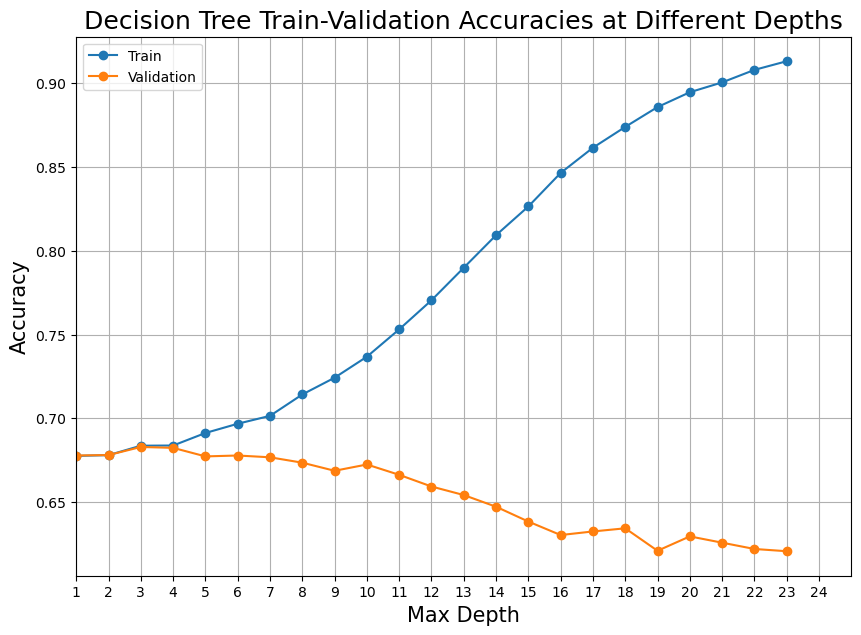

In [64]:
plt.figure(figsize=(10,7))
plt.plot(train_acc, label='Train', marker='o')
plt.plot(val_acc, label='Validation', marker='o')
plt.xticks(np.arange(1,25, step=1))
plt.xlim(1,25)
plt.xlabel('Max Depth', size=15)
plt.ylabel("Accuracy", size=15)
plt.title('Decision Tree Train-Validation Accuracies at Different Depths', size=18)
plt.grid()
plt.legend()

plt.show()

In [65]:
# Fit with max_depth of 20

MyTree = DecisionTreeClassifier(max_depth=4)

MyTree.fit(X_remainderB, y_remainderB)

MyTree.score(X_remainderB, y_remainderB)


0.6841893414909033

In [66]:
MyTree.score(X_testB, y_testB)

0.6801277235161532

Logistic Regression

In [67]:
# test with validation and train
scale1 = MinMaxScaler()

scale1.fit(X_trainB)

X_train_scaledB = scale1.transform(X_trainB)

X_validation_scaledB = scale1.transform(X_validationB)

In [68]:
train_acc = list()
val_acc = list()

Cs = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

for C in Cs:

    LR = LogisticRegression(C=C, max_iter=10000, solver='saga', penalty='l2')

    LR.fit(X_train_scaledB, y_trainB)
    LR.fit(X_train_scaledB, y_trainB)
    

    TAC = LR.score(X_train_scaledB, y_trainB)
    VAC = LR.score(X_validation_scaledB, y_validationB)

    train_acc.append(TAC)
    val_acc.append(VAC)

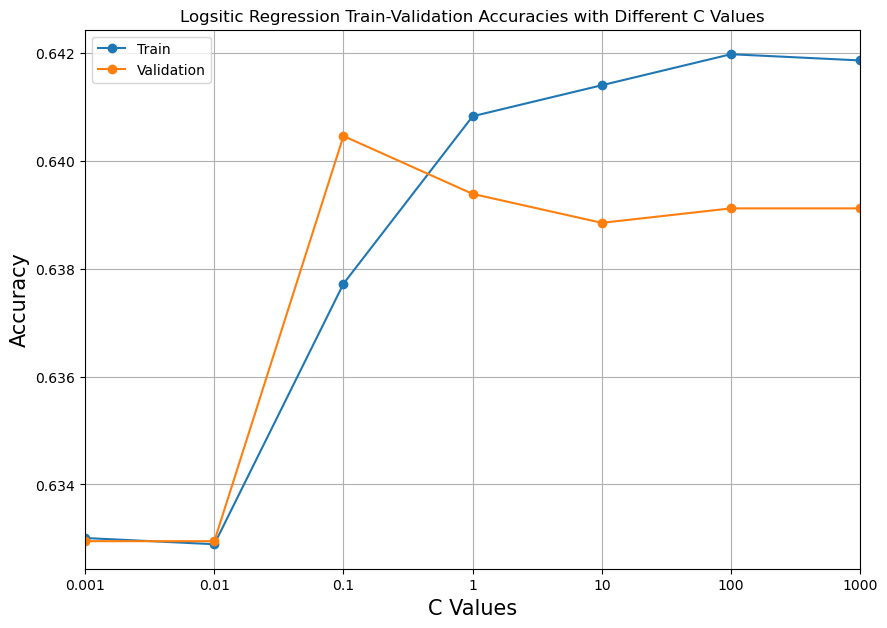

In [69]:
plt.figure(figsize=(10,7))
plt.plot(train_acc, label='Train', marker='o')
plt.plot(val_acc, label='Validation', marker='o')
plt.xticks([0,1,2,3,4,5,6], labels=Cs)
plt.xlabel('C Values', size=15)
plt.ylabel("Accuracy", size=15)
plt.title("Logsitic Regression Train-Validation Accuracies with Different C Values")
plt.xlim(0,6)
plt.grid()
plt.legend()

plt.show()

KNN

In [70]:
train_acc = list()
val_acc = list()

Ks = (np.arange(1,200, step=5))

for K in Ks:
    KNN = KNeighborsClassifier(n_neighbors=K)

    KNN.fit(X_train_scaledB, y_trainB)

    TAC = KNN.score(X_train_scaledB, y_trainB)
    VAC = KNN.score(X_validation_scaledB, y_validationB)

    train_acc.append(TAC)
    val_acc.append(VAC)

In [71]:
labels=list(Ks)

In [72]:
len(train_acc)

40

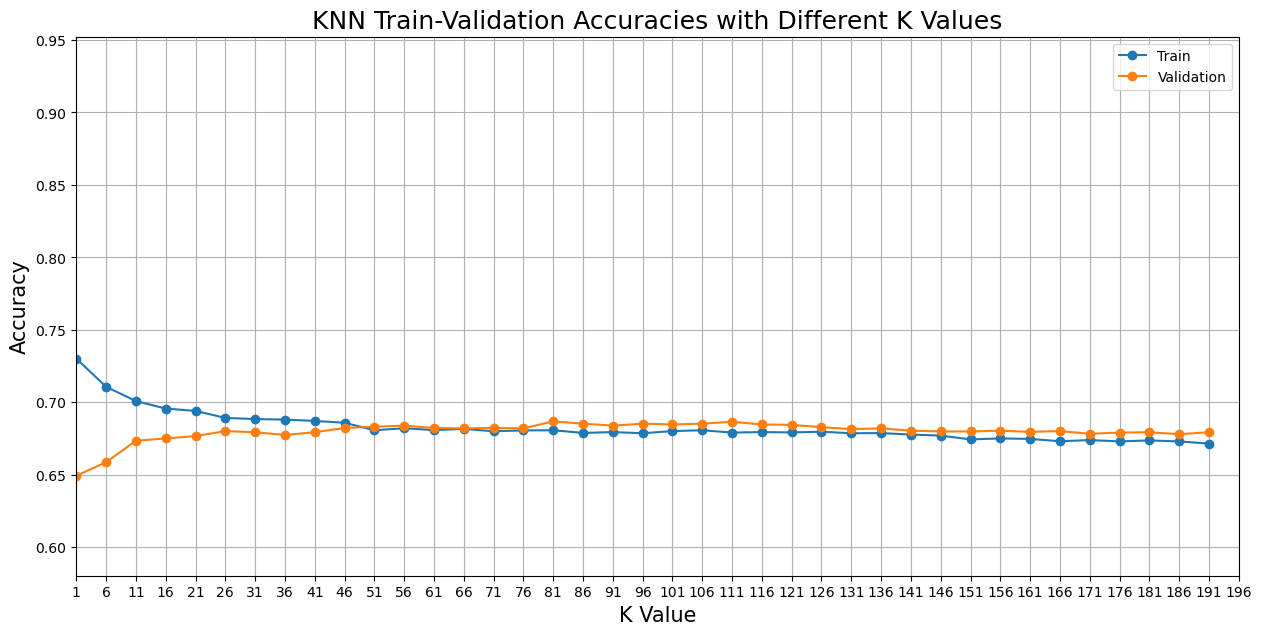

In [73]:
plt.figure(figsize=(15,7))
plt.plot(train_acc, label='Train', marker='o')
plt.plot(val_acc, label='Validation', marker='o')
plt.xticks((np.arange(1,41, step=1)), labels=labels)
plt.xlim(1,40)
plt.xlabel('K Value', size=15)
plt.ylabel("Accuracy", size=15)
plt.title("KNN Train-Validation Accuracies with Different K Values", size=18)
plt.grid()
plt.legend()

plt.show()

In [74]:
# fittedgrid.score(X_trainB, y_trainB)

In [75]:

# fittedgrid.score(X_validationB, y_validationB)


In [76]:
# fittedgrid.best_params_